# 1-Neutral Curve

In [1]:
using DifferentialEquations
using PyPlot
using FileIO
include("GalerkinFuncs.jl");

# Setup the model

In [2]:
# Model parameters
N  = 10
c1 = 0.1
c2 = 0.06
K  = 0.72
xf = 0.25
τ  = 0.2
Ma = 0.005
γ  = 1.4
# Create a structure of parameters
params = setParams(N,c1,c2,K,xf,τ,true);

#####################################
## Rijke tube Galerkin modes model ##
#####################################

##  Parameters ##
N  = 10
c1 = 0.1
c2 = 0.06
K  = 0.72
xf = 0.25
τ  = 0.2
#################



# Run the model to see the behaviour

In [3]:
# Solve the direct equation
u0 = load("data/init.jld", "u0");
h(p,t) = u0
tMax  = 400
tspan = (-400,tMax+3)
lags = [params.τ]
prob = DDEProblem(RHS,u0,h,tspan,params,constant_lags=lags,reltol=1e-12)
alg = MethodOfSteps(Vern6())
@time solDir = solve(prob,alg);

 12.845089 seconds (127.87 M allocations: 7.084 GiB, 9.56% gc time)


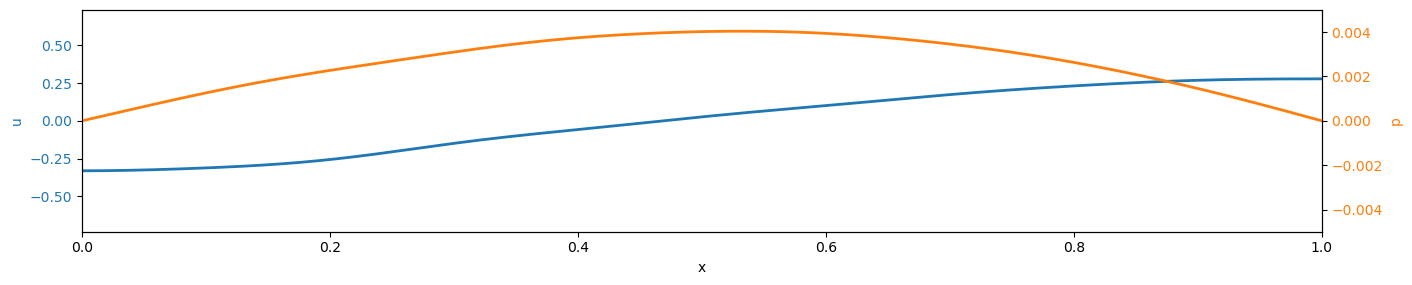

(0.0, 1.0)

In [4]:
# Plot the pressure and velocity profiles
x = range(0,stop=1,length=400) 
u, p = pressureVelocity(solDir(0.11711316059142148),x,params)

width, height = plt[:figaspect](0.18)
figure(figsize=(width,height))

plt1 = plot(x,u,linewidth=2,label="u")
val = maximum(abs.(u))*1.1
ylim([-0.735,0.735])
xlabel("x")
ylabel("u",color="C0")
ax = gca()
setp(ax.get_yticklabels(),color="C0")
axright = twinx()
val = maximum(abs.(p))*1.1
ylim([-0.005,0.005])
plt2 = plot(x,p,linewidth=2,color="C1",label="p")
ylabel("p",color="C1");
setp(axright.get_yticklabels(),color="C1")
xlim([0,1])

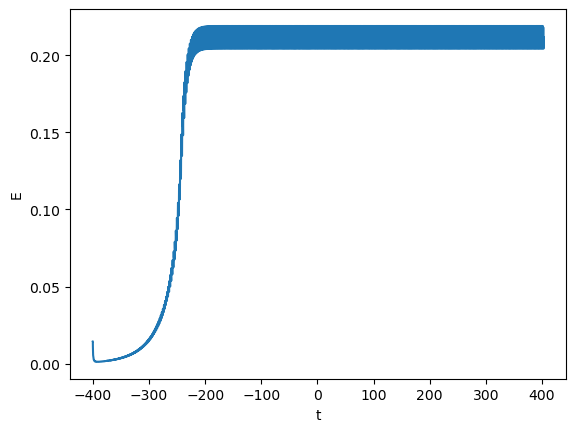

PyObject Text(24.000000000000007, 0.5, 'E')

In [5]:
# Plot of the energy against time
EVec = zeros(length(solDir.t),1)
for i=1:length(solDir.t)
    EVec[i]=energy(solDir.u[i],params)
end
plot(solDir.t,EVec)
xlabel("t")
ylabel("E")

# Compute the eigenvalues of the steady state

In [6]:
using NonlinearEigenproblems

In [7]:
# Linearise about the base state (u=0,p=0)
zeroBaseState = zeros(2N,1)
A1 = Array(params.A1);
A2 = Array(linHeatReleaseMat(zeroBaseState,params));

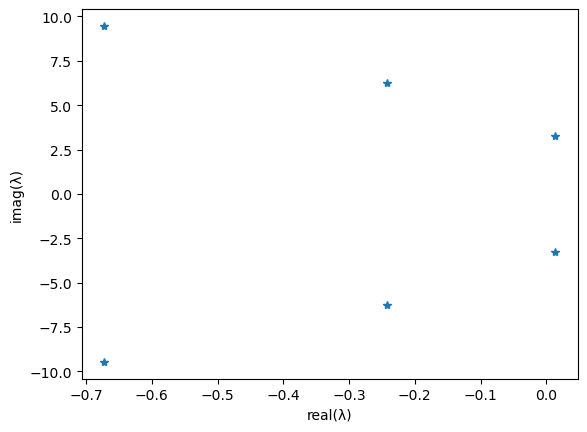

In [8]:
# Spectrum at the base state
A1 = Array(params.A1);
A2 = Array(linHeatReleaseMat(zeros(2*N,1),params));
dep=DEP([A1, A2],[0,params.τ]);
λ,V=iar_chebyshev(dep,maxit=100);
plot(real(λ),imag(λ),"*");
xlabel("real(λ)"); ylabel("imag(λ)");

## Find the neutral curve

In [9]:
# Find the neutral curve
@time begin
τs = range(0.01,stop=0.9,length=20)
Ks = range(0.01,3.5,length=21)
Growth = zeros(20,21)
for (i,τv) in enumerate(τs)
    for (j,Kv) in enumerate(Ks)
        params = setParams(N,c1,c2,Kv,xf,τv);
        A1 = Array(params.A1);
        A2 = Array(linHeatReleaseMat(zeros(2N,1),params));
        dep=DEP([A1, A2],[0,params.τ]);
        λ,V=iar_chebyshev(dep,maxit=100);
        Growth[i,j] = maximum(real(λ))
    end
end
end

 11.135551 seconds (13.65 M allocations: 5.275 GiB, 3.05% gc time)


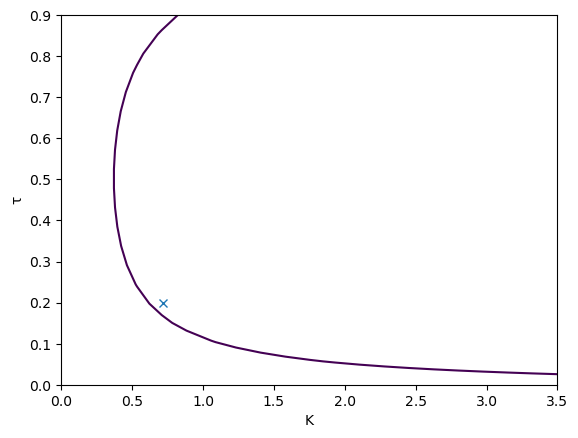

In [10]:
# Plot the neutral stability curve
contour(Ks,τs,Growth,levels=[0])
# Location of the base case
plot(0.72,0.2,"x")
ylim([0,0.9])
xlim([0,3.5])
xlabel("K"); ylabel("τ");